# **Project Title: Predicting "Timeless" Music Tracks Using a Deep Learning Approach**

---

## **Definition of the Problem**
In this project, we aim to predict whether a music track is "timeless" or not, based on its audio and metadata attributes. We define a "timeless" track as one whose popularity is within the top 20% of all tracks in the dataset. Our goal is to build a predictive model that classifies tracks into timeless or not timeless. This will be useful for music streaming services and record labels to identify songs that are likely to remain popular over time.

**Business Objective / Value**  
The model’s predictions can help businesses:
1. **Recommend** older (or newly released) music with high timelessness potential to users.
2. **Strategize** marketing efforts for new releases.
3. **Enhance** playlist curation for long-term user engagement.

**Performance Metric**  
We will focus on:
- **Accuracy** for overall performance
- **ROC AUC** for understanding how well the model distinguishes between timeless and not timeless tracks.
- **Precision & Recall** for each class to ensure balance, especially since popularity can be skewed.

---


# **Cell 1: Import Libraries**

Below, we import all the necessary libraries required for data manipulation, visualization, preprocessing, model building, and evaluation.


In [1]:
# Cell 1: Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# For handling imbalanced data
from imblearn.over_sampling import SMOTE

# For feature selection
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# For text feature extraction
from textblob import TextBlob

# Additional Models for Comparison
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')


# **Cell 2: Load and Explore Data**

1. We load the dataset from a CSV file named "spotify.csv".
2. We show basic information using `.info()`.
3. We display descriptive statistics using `.describe()`.
4. We preview the first few rows of the dataset using `.head()`.

This step helps us understand the size of the dataset, its columns, data types, missing values, and overall structure.


In [2]:
# Cell 2: Load and Explore Data

# Load the dataset
spotify = pd.read_csv('spotify.csv')

# Basic info
print(f"The dataset contains {spotify.shape[0]} rows and {spotify.shape[1]} columns.")
spotify.info()

# Descriptive statistics
display(spotify.describe())

# Preview the data
display(spotify.head())


The dataset contains 586672 rows and 20 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  5

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,586672.000000,5.866720e+05,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000
mean,27.570053,2.300512e+05,0.044086,0.563594,0.542036,5.221603,-10.206067,0.658797,0.104864,0.449863,0.113451,0.213935,0.552292,118.464857,3.873382
std,18.370642,1.265261e+05,0.205286,0.166103,0.251923,3.519423,5.089328,0.474114,0.179893,0.348837,0.266868,0.184326,0.257671,29.764108,0.473162
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,1.750930e+05,0.000000,0.453000,0.343000,2.000000,-12.891000,0.000000,0.034000,0.096900,0.000000,0.098300,0.346000,95.600000,4.000000
50%,27.000000,2.148930e+05,0.000000,0.577000,0.549000,5.000000,-9.243000,1.000000,0.044300,0.422000,0.000024,0.139000,0.564000,117.384000,4.000000
75%,41.000000,2.638670e+05,0.000000,0.686000,0.748000,8.000000,-6.482000,1.000000,0.076300,0.785000,0.009550,0.278000,0.769000,136.321000,4.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


## **Additional Exploratory Data Analysis (EDA)**

Before we move on to data cleaning and preparation, let's perform some additional EDA to better understand the dataset.

1. **Distribution of `popularity`**: Checking how popularity is distributed can help us see if it's skewed.
2. **Correlation Heatmap**: To observe how numeric features correlate with each other and with `popularity`.
3. **Pairplot / Histograms**: To get a sense of the distribution of important audio features.

By visualizing these aspects, we gain further insights into our data, which can guide our data cleaning and modeling decisions.


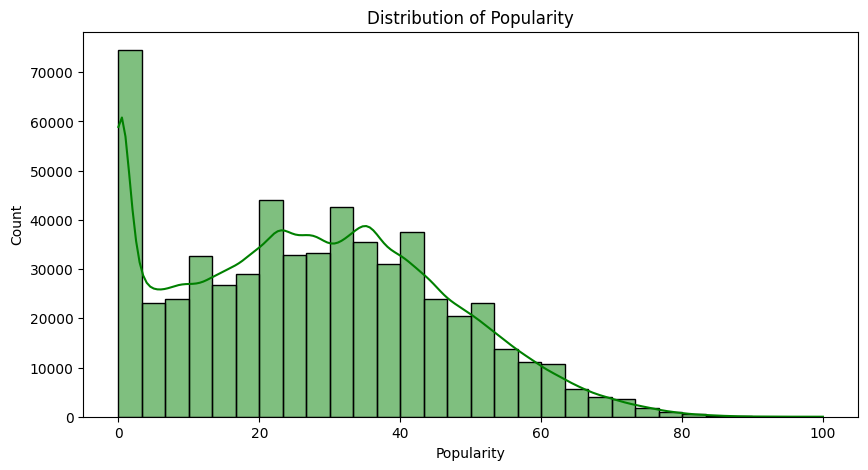

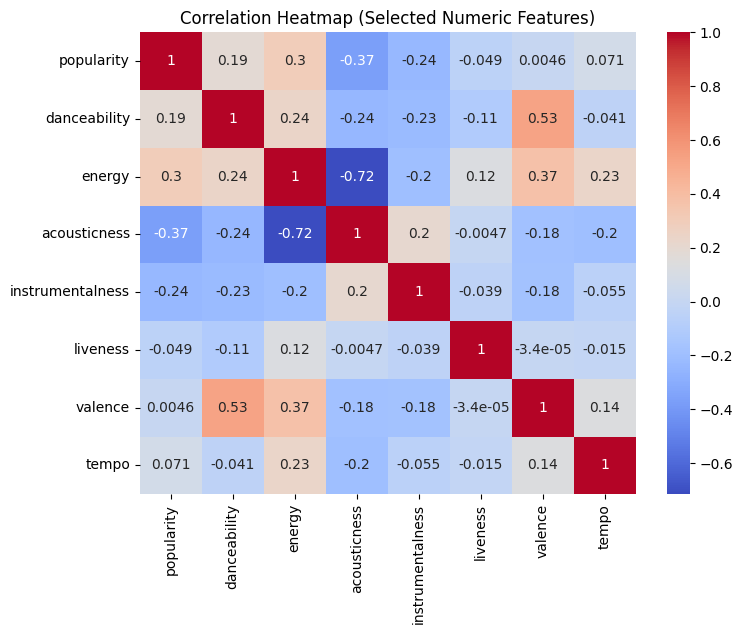

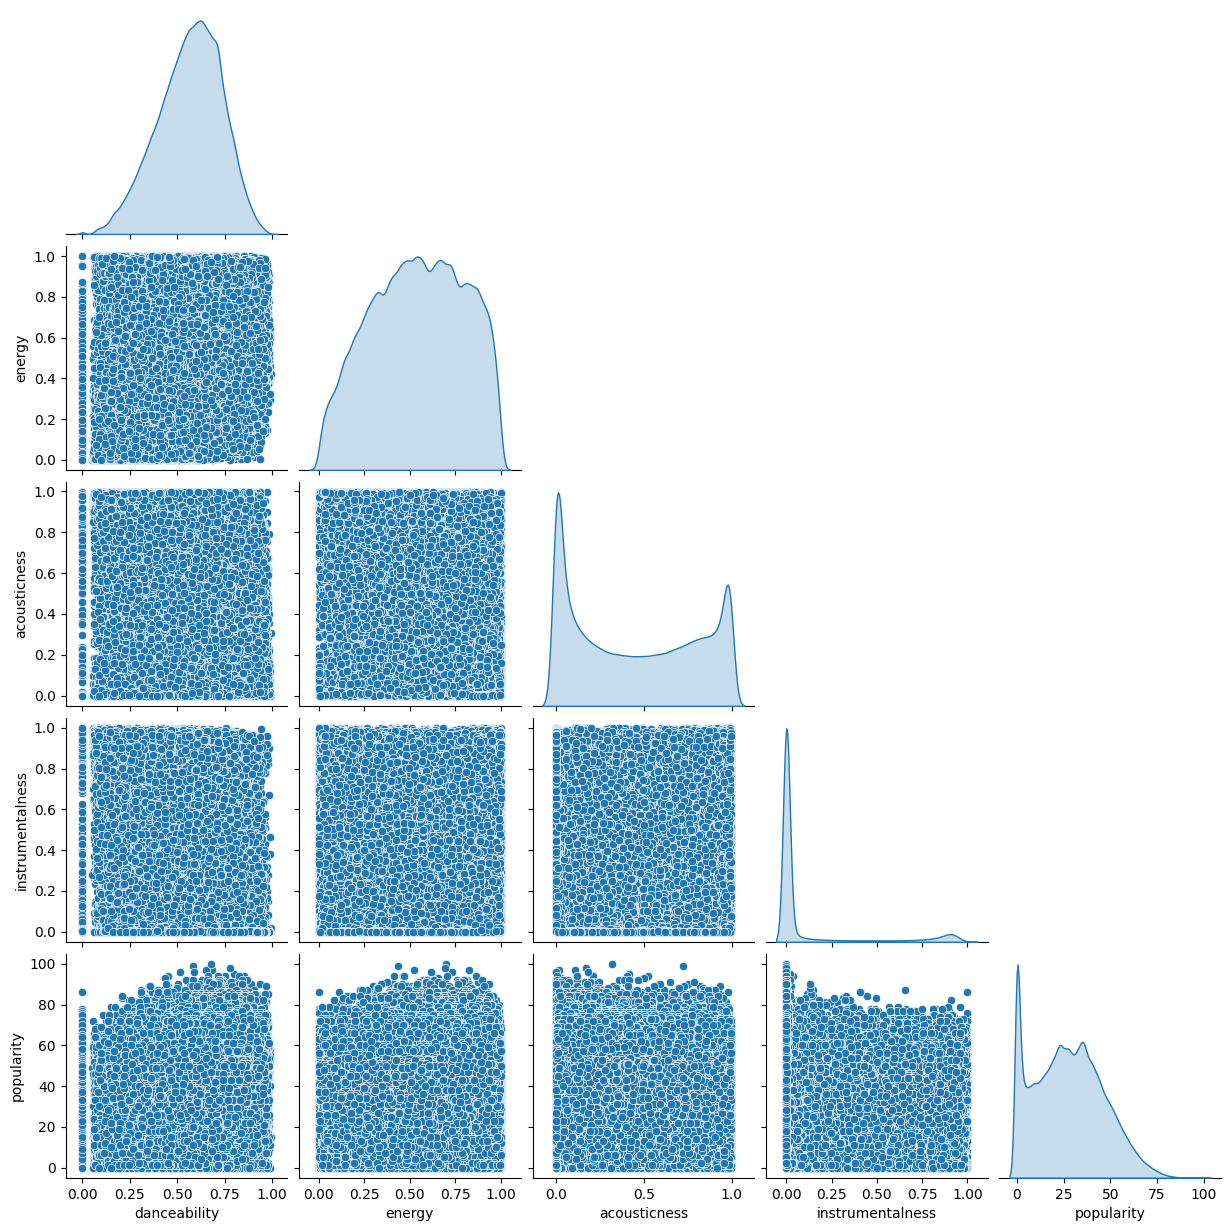

In [3]:
# Additional EDA Cell

# 1. Distribution of 'popularity'
plt.figure(figsize=(10, 5))
sns.histplot(spotify['popularity'], bins=30, kde=True, color='green')
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

# 2. Correlation Heatmap of numeric columns (limited to a few columns for clarity)
numeric_cols = ['popularity','danceability','energy','acousticness','instrumentalness','liveness','valence','tempo']
corr_matrix = spotify[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Selected Numeric Features)')
plt.show()

# 3. Pairplot for a subset of numeric features
subset_cols = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'popularity']
sns.pairplot(spotify[subset_cols], diag_kind='kde', corner=True)
plt.show()


### 1. Distribution of Popularity
- **Observation**: Highly skewed distribution with many tracks having low popularity (near 0), and fewer tracks in the higher popularity range.  
- **Insight**: Popularity is imbalanced, requiring thresholding or transformations to account for class distribution.  

---

### 2. Correlation Heatmap
- **Key Correlations**:  
  - **Popularity** has weak positive correlations with **danceability (0.19)** and **energy (0.24)**.  
  - **Acousticness (-0.37)** shows a moderate negative correlation with popularity.  
  - No strong multicollinearity between features.  
- **Insight**: Acousticness, energy, and danceability may influence model predictions, while others contribute minimally.

---

### 3. Pairplot
- **Observation**: Weak linear relationships between popularity and most features. Variations across features are diverse (e.g., **energy** and **acousticness** distributions are distinct).  
- **Insight**: Relationships are non-linear, necessitating advanced models like Neural Networks to capture patterns effectively.
---


# **Cell 3: Data Cleaning and Preprocessing**

We perform the following:
- **Remove Unneeded Columns**: Drop `id` and `id_artists` to avoid unnecessary data.
- **Handle Missing Values**: Drop any rows with missing values.
- **Remove Duplicates**: Ensure there are no exact duplicate rows.
- **Extract `release_year`**: Convert release date strings to a year.
- **Filter Data**: Only consider tracks released between 1920 and 2020 and remove tracks with `popularity = 0`.
- **Reset Index**: For a tidy, re-indexed dataset.

These steps ensure our dataset is cleaned and focused on relevant information.


In [4]:
# Cell 3: Data Cleaning and Preprocessing

# Remove columns not needed
columns_to_remove = ['id', 'id_artists']
spotify.drop(columns=columns_to_remove, inplace=True, errors='ignore')

# Remove missing values
spotify.dropna(inplace=True)

# Remove duplicates
spotify.drop_duplicates(inplace=True)

# Extract release year
def extract_year(date):
    try:
        if '/' in str(date):
            return int(str(date).split('/')[-1])
        elif '-' in str(date):
            return int(str(date).split('-')[0])
        else:
            return int(str(date))
    except:
        return np.nan

spotify['release_year'] = spotify['release_date'].apply(extract_year)
spotify.dropna(subset=['release_year'], inplace=True)

# Consider tracks from 1920 to 2020
spotify = spotify[(spotify['release_year'] >= 1920) & (spotify['release_year'] <= 2020)]

# Remove rows where popularity is 0 (if desired)
spotify = spotify[spotify['popularity'] > 0]

# Reset index after filtering
spotify.reset_index(drop=True, inplace=True)

print(f"Dataset shape after cleaning: {spotify.shape}")


Dataset shape after cleaning: (536621, 19)


# **Cell 4: Create Target Variable**

We define “Timelessness” as a binary label:
- **1 (Timeless)** if the track’s popularity is above the 80th percentile.
- **0 (Not Timeless)** otherwise.

We also visualize the distribution of the newly created target variable to see how our dataset is divided between timeless and not timeless tracks.


Timelessness counts before outlier removal and resampling:
timelessness
0    427891
1    108730
Name: count, dtype: int64


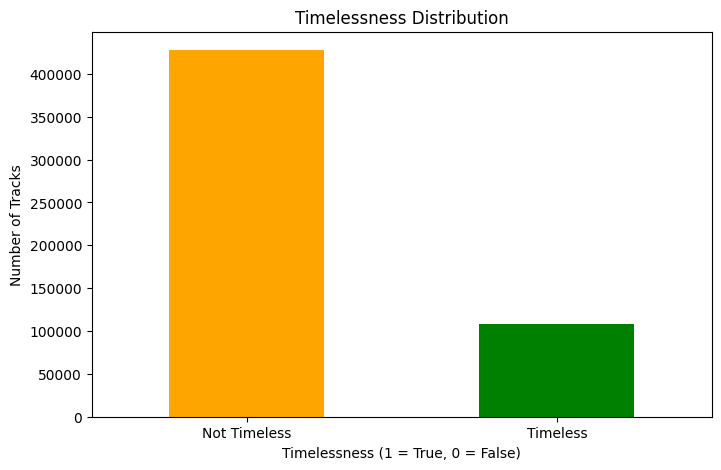

In [5]:
# Cell 4: Create Target Variable

# Dynamic Threshold based on Percentiles (e.g., top 20% as timeless)
threshold = spotify['popularity'].quantile(0.8)
spotify['timelessness'] = spotify['popularity'].apply(lambda x: 1 if x >= threshold else 0)

timeless_counts = spotify['timelessness'].value_counts()
print("Timelessness counts before outlier removal and resampling:")
print(timeless_counts)

plt.figure(figsize=(8, 5))
timeless_counts.plot(kind='bar', color=['orange', 'green'])
plt.title('Timelessness Distribution')
plt.xlabel('Timelessness (1 = True, 0 = False)')
plt.ylabel('Number of Tracks')
plt.xticks(ticks=[0, 1], labels=['Not Timeless', 'Timeless'], rotation=0)
plt.show()


# **Cell 5: Advanced Feature Engineering**

Although the dataset already contains various audio features, here we create additional features to potentially capture deeper patterns:
1. **Temporal Features**: `decade` and `age`.
2. **Artist Features**: `num_artists` (number of contributing artists) and `primary_artist` frequency encoding.
3. **Audio Feature Interactions**: `dance_energy` and `acoustic_instrumental`.
4. **Polynomial Features**: We capture non-linear relationships by generating 2nd-degree polynomial interactions among audio features.

These transformations can help the model learn more complex patterns from the data.


In [6]:
# Cell 5: Advanced Feature Engineering

# 1. Temporal Features
# Create 'decade' feature
spotify['decade'] = (spotify['release_year'] // 10) * 10

# Create 'age' feature as the number of years since release
spotify['age'] = 2024 - spotify['release_year']

# 2. Artist Features
# Number of artists involved
spotify['num_artists'] = spotify['artists'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 1)

# Extract primary artist for frequency encoding
spotify['primary_artist'] = spotify['artists'].apply(lambda x: eval(x)[0] if isinstance(x, str) and len(eval(x)) > 0 else 'Unknown')
artist_freq = spotify['primary_artist'].value_counts()
spotify['artist_freq'] = spotify['primary_artist'].map(artist_freq)

# 3. Audio Features Interactions
spotify['dance_energy'] = spotify['danceability'] * spotify['energy']
spotify['acoustic_instrumental'] = spotify['acousticness'] * spotify['instrumentalness']

# 4. Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
audio_features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 
                  'liveness', 'valence', 'tempo', 'dance_energy', 'acoustic_instrumental']
poly_features = poly.fit_transform(spotify[audio_features])
poly_feature_names = poly.get_feature_names_out(audio_features)

# Create a DataFrame with polynomial features
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
poly_df.index = spotify.index

# Concatenate polynomial features to the main dataframe
spotify = pd.concat([spotify, poly_df], axis=1)

print(f"Shape after feature engineering: {spotify.shape}")


Shape after feature engineering: (536621, 82)


# **Cell 6: Categorical Variable Encoding**

We handle our categorical variables through a combination of:
1. **Dropping high-cardinality or irrelevant columns.**
2. **Label Encoding** for very high-cardinality features (reduce unique categories).
3. **One-Hot Encoding** for the remaining categorical variables (like `decade`, `key`, `mode`, etc.).

By converting categorical columns to numeric form, we make them understandable by machine learning models.


In [7]:
# Cell 6: Categorical Variable Encoding

# Identify categorical columns
categorical_cols = spotify.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

# Drop high-cardinality or irrelevant categorical columns
columns_to_drop = ['name', 'primary_artist']
spotify.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Update categorical columns after dropping
categorical_cols = spotify.select_dtypes(include=['object']).columns.tolist()
print("Remaining categorical columns:", categorical_cols)

# One-Hot Encode categorical variables
# Categorical features: 'decade', 'key', 'mode', 'time_signature'
# Convert 'mode' to string for encoding
spotify['mode'] = spotify['mode'].astype(str)
spotify['key'] = spotify['key'].astype(str)
spotify['time_signature'] = spotify['time_signature'].astype(str)
spotify['decade'] = spotify['decade'].astype(str)

from sklearn.preprocessing import LabelEncoder
# Identify high-cardinality columns
high_cardinality_cols = [col for col in categorical_cols if spotify[col].nunique() > 100]

# Reduce cardinality by grouping less frequent categories into 'Other'
for col in high_cardinality_cols:
    top_categories = spotify[col].value_counts().nlargest(100).index
    spotify[col] = spotify[col].apply(lambda x: x if x in top_categories else 'Other')

# Update categorical columns after reducing cardinality
categorical_cols = spotify.select_dtypes(include=['object']).columns.tolist()
# Initialize LabelEncoder
label_encoders = {col: LabelEncoder() for col in high_cardinality_cols}

# Fit and transform high-cardinality columns
for col, encoder in label_encoders.items():
    spotify[col] = encoder.fit_transform(spotify[col])

# Update categorical columns after label encoding
categorical_cols = [col for col in categorical_cols if col not in high_cardinality_cols]

# One-Hot Encode remaining categorical variables
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_cats = encoder.fit_transform(spotify[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))
encoded_cat_df.index = spotify.index

# Concatenate encoded categorical features to the main dataframe
spotify = pd.concat([spotify, encoded_cat_df], axis=1)

# Drop original categorical columns
spotify.drop(columns=categorical_cols, inplace=True)

print(f"Shape after encoding categorical variables: {spotify.shape}")


Categorical columns: ['name', 'artists', 'release_date', 'primary_artist']
Remaining categorical columns: ['artists', 'release_date']
Shape after encoding categorical variables: (536621, 102)


# **Cell 7: Handle Class Imbalance with SMOTE**

Because the dataset may be imbalanced (fewer timeless tracks compared to non-timeless), we apply **SMOTE** (Synthetic Minority Over-sampling Technique) to artificially balance the classes. This generates new synthetic samples for the minority class based on the feature space.


Class distribution before resampling:
timelessness
0    427891
1    108730
Name: count, dtype: int64


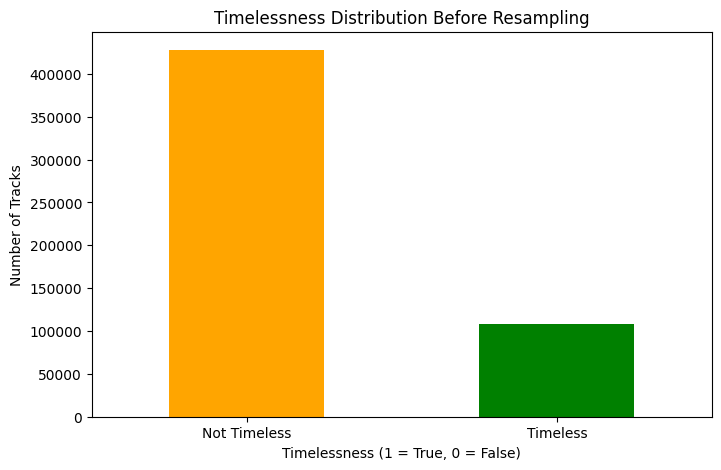

Class distribution after resampling:
timelessness
0    427891
1    427891
Name: count, dtype: int64


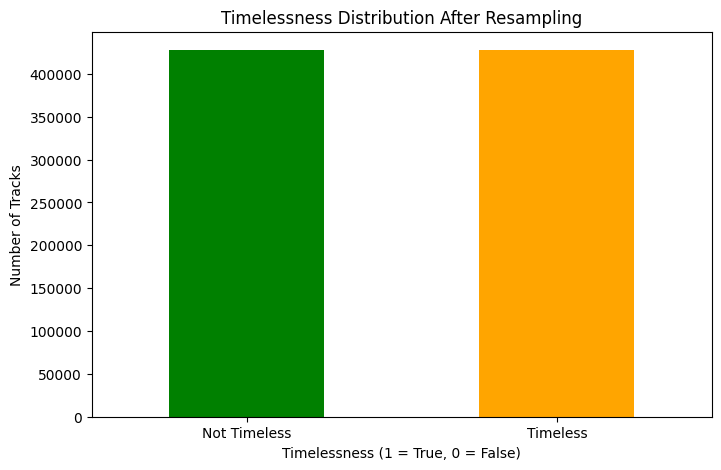

In [8]:
# Cell 7: Handle Class Imbalance with SMOTE

# Separate features and target
X = spotify.drop(columns=['timelessness', 'popularity', 'release_date', 'artists'])
y = spotify['timelessness']

# Display class distribution
print("Class distribution before resampling:")
print(y.value_counts())

# Plot class distribution
plt.figure(figsize=(8, 5))
y.value_counts().plot(kind='bar', color=['orange', 'green'])
plt.title('Timelessness Distribution Before Resampling')
plt.xlabel('Timelessness (1 = True, 0 = False)')
plt.ylabel('Number of Tracks')
plt.xticks(ticks=[0, 1], labels=['Not Timeless', 'Timeless'], rotation=0)
plt.show()

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Display class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_resampled).value_counts())

# Plot class distribution after resampling
plt.figure(figsize=(8, 5))
pd.Series(y_resampled).value_counts().plot(kind='bar', color=['green', 'orange'])
plt.title('Timelessness Distribution After Resampling')
plt.xlabel('Timelessness (1 = True, 0 = False)')
plt.ylabel('Number of Tracks')
plt.xticks(ticks=[0, 1], labels=['Not Timeless', 'Timeless'], rotation=0)
plt.show()


# **Cell 8: Feature Scaling and Transformation**

Most machine learning algorithms perform better when numerical features are on a similar scale. Hence, we apply **StandardScaler** to transform the numeric columns, centering them around 0 with unit variance.


In [9]:
# Cell 8: Feature Scaling and Transformation

# Identify numerical columns for scaling
numerical_cols = X_resampled.select_dtypes(include=[np.number]).columns.tolist()

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform numerical features
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])

print("Feature scaling applied to numerical features.")


Feature scaling applied to numerical features.


# **Cell 9: Train-Validation-Test Split**

We split the resampled dataset into **training (60%)**, **validation (20%)**, and **test (20%)** sets. 
- Training data is for learning model parameters.
- Validation data helps us monitor overfitting and tune hyperparameters.
- Test data is for the final performance evaluation.


In [10]:
# Cell 9: Train-Validation-Test Split

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.4, stratify=y_resampled, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

print("\nClass distribution in y_train:")
print(pd.Series(y_train).value_counts())

print("\nClass distribution in y_val:")
print(pd.Series(y_val).value_counts())

print("\nClass distribution in y_test:")
print(pd.Series(y_test).value_counts())


Training set size: 513469
Validation set size: 171156
Test set size: 171157

Class distribution in y_train:
timelessness
1    256735
0    256734
Name: count, dtype: int64

Class distribution in y_val:
timelessness
0    85578
1    85578
Name: count, dtype: int64

Class distribution in y_test:
timelessness
0    85579
1    85578
Name: count, dtype: int64


## **Cell 9B: Logistic Regression Model (Comparison)**

To compare with our eventual deep learning model, let's train a **Logistic Regression** classifier. Logistic Regression is a good baseline for binary classification tasks:

1. **Train** using `X_train` and `y_train`.
2. **Evaluate** on the test set for a fair comparison.
3. **Generate** confusion matrix and classification report.




--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     85579
           1       0.91      0.83      0.87     85578

    accuracy                           0.88    171157
   macro avg       0.88      0.88      0.88    171157
weighted avg       0.88      0.88      0.88    171157

ROC AUC Score: 0.9454


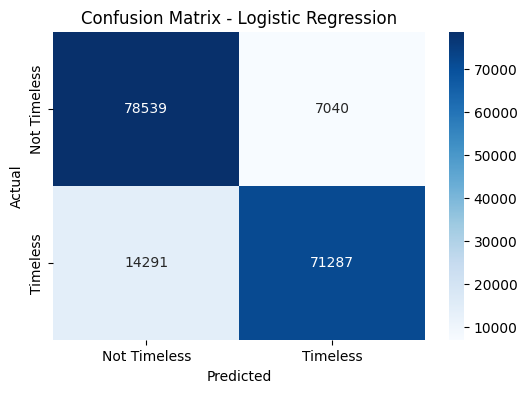

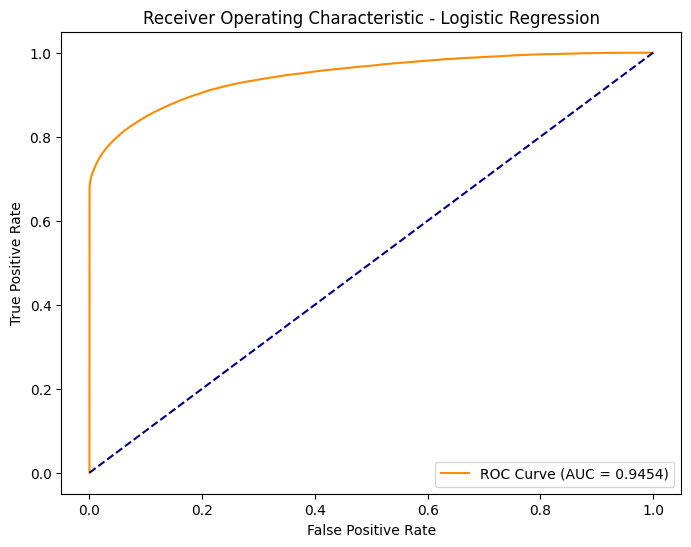

In [11]:
# Cell 9B: Logistic Regression Model (Comparison)

# Create and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict probabilities and classes on the test set
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]
y_pred_lr = log_reg.predict(X_test)

# Calculate metrics
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print("\n--- Logistic Regression ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC Score: {roc_auc_lr:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Timeless', 'Timeless'],
            yticklabels=['Not Timeless', 'Timeless'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# ROC Curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


### Logistic Regression Analysis and Interpretation

- **Accuracy**: The model achieved **88%**, indicating strong overall performance.
- **Precision**: Higher for "Timeless" (**91%**) compared to "Not Timeless" (**85%**), showing good positive prediction reliability.
- **Recall**: Lower for "Timeless" (**83%**) compared to "Not Timeless" (**92%**), meaning some timeless tracks are missed.
- **AUC**: **0.9454 (94.54%)**, showcasing excellent class separation ability.
- **Confusion Matrix**:
  - **TP (Timeless)**: **71,287**
  - **FP (Not Timeless misclassified as Timeless)**: **7,040**
  - **FN (Timeless misclassified as Not Timeless)**: **14,291**

#### Key Observations
- The model performs well overall but has **high false negatives** for the "Timeless" class.
- **Recommendation**: Adjust the threshold or enhance features to improve recall for "Timeless" tracks.
---

## **Cell 9C: SVM Model (Comparison)**

For another classical machine learning comparison, let's train a **Support Vector Machine (SVM)**. SVMs can be computationally expensive on large datasets, so we **limit it to 50,000 samples** from the **resampled** data to reduce training time:

1. We randomly select up to 50,000 data points from the training set.
2. Train the SVM (we'll use a linear or RBF kernel for demonstration).
3. Evaluate on the test set.



--- Support Vector Machine ---
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     85579
           1       0.84      0.82      0.83     85578

    accuracy                           0.83    171157
   macro avg       0.83      0.83      0.83    171157
weighted avg       0.83      0.83      0.83    171157

ROC AUC Score: 0.9148


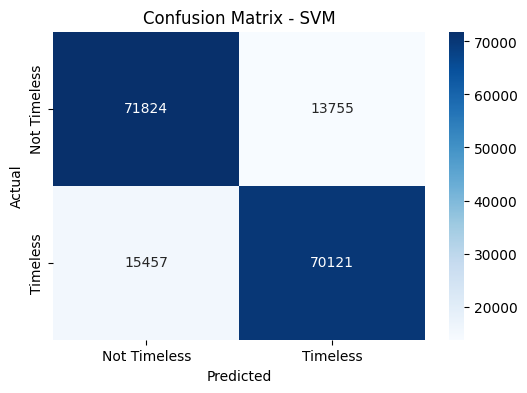

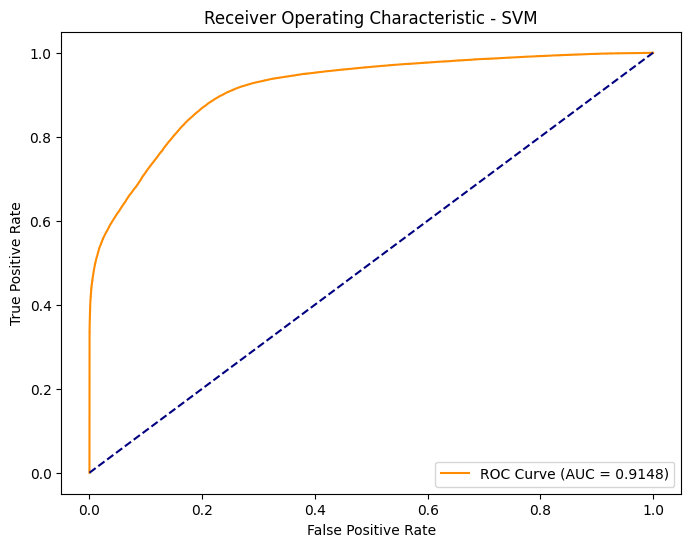

In [12]:
# Cell 9C: SVM Model (Comparison)
# Limit SVM to 50,000 samples for computational efficiency

max_samples = 50000
if X_train.shape[0] > max_samples:
    # Randomly sample 50,000 from the training set
    sample_indices = np.random.choice(X_train.index, size=max_samples, replace=False)
    X_train_svm = X_train.loc[sample_indices]
    y_train_svm = y_train.loc[sample_indices]
else:
    X_train_svm = X_train
    y_train_svm = y_train

# Create and train the SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_svm, y_train_svm)

# Predict probabilities and classes on the test set
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]
y_pred_svm = svm_model.predict(X_test)

# Calculate metrics
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)

print("\n--- Support Vector Machine ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))
print(f"ROC AUC Score: {roc_auc_svm:.4f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Timeless', 'Timeless'],
            yticklabels=['Not Timeless', 'Timeless'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SVM')
plt.show()

# ROC Curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_proba_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'ROC Curve (AUC = {roc_auc_svm:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic - SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


### Support Vector Machine (SVM) Interpretation and Analysis

- **Accuracy**: **83%**, indicating good performance but slightly lower than Logistic Regression.
- **Precision**: Higher for "Timeless" (**84%**) than "Not Timeless" (**82%**), showing reliable predictions for the positive class.
- **Recall**:  
  - Not Timeless: **84%**  
  - Timeless: **82%**, meaning some timeless tracks are missed.
- **AUC**: **0.9148 (91.48%)**, demonstrating strong ability to distinguish between classes.

#### Confusion Matrix Insights:
- **True Positives (Timeless correctly predicted)**: **70,121**  
- **False Negatives (Timeless misclassified as Not Timeless)**: **15,457**  
- **False Positives (Not Timeless misclassified as Timeless)**: **13,755**

#### Observations:
- Higher **false negatives** (15,457) reduce recall for the Timeless class.
- Model requires significant computational resources, as only **50,000 samples** were used for training.
---

# **Cell 10: Build and Train Improved Neural Network**

We now design and train our **deep learning model**, which is a feed-forward neural network with:
- Multiple **Dense** layers
- **BatchNormalization** for stable training
- **Dropout** for regularization
- **EarlyStopping** to prevent overfitting

We'll compare this model’s performance with the classical models (Logistic Regression, SVM).


Epoch 1/100
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.6963 - loss: 0.6024 - val_accuracy: 0.7859 - val_loss: 0.4646
Epoch 2/100
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7778 - loss: 0.4782 - val_accuracy: 0.8079 - val_loss: 0.4121
Epoch 3/100
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7948 - loss: 0.4415 - val_accuracy: 0.8278 - val_loss: 0.3727
Epoch 4/100
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8067 - loss: 0.4142 - val_accuracy: 0.8383 - val_loss: 0.3521
Epoch 5/100
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8144 - loss: 0.3969 - val_accuracy: 0.8421 - val_loss: 0.3408
Epoch 6/100
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8202 - loss: 0.3846 - val_accuracy: 0.8466 - val_loss: 0.3320
Epoch 7/100
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8247 - loss: 0.3736 - val_accuracy: 0.8499 - val_loss: 0.3250
Epoch 8/100
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8284

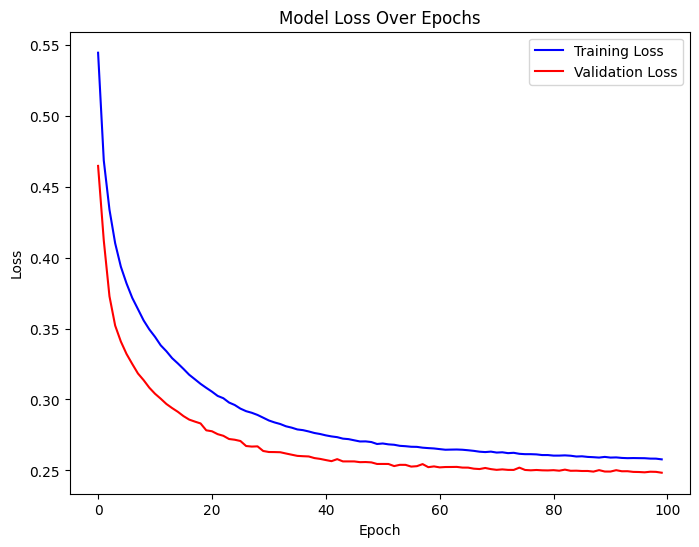

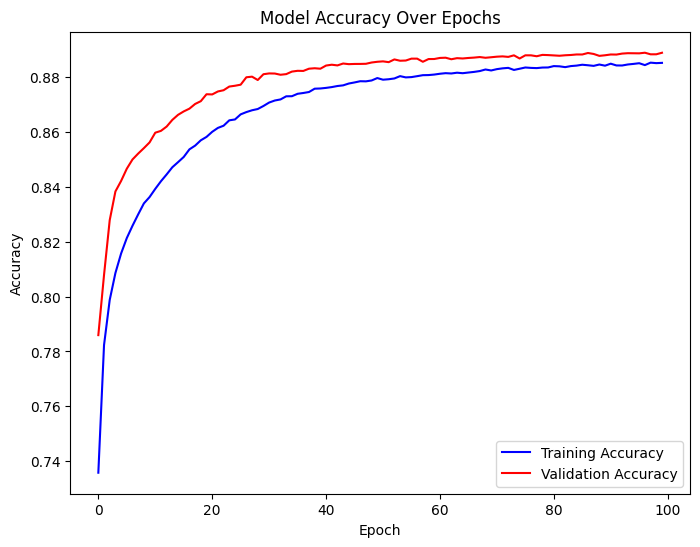

In [13]:
# Cell 10: Build and Train Improved Neural Network

# Define input dimension
input_dim = X_train.shape[1]

# Build the Neural Network model
nn_model = Sequential([
    Dense(256, input_dim=input_dim, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
nn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = nn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=[early_stop]
)

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


### Training and Validation Loss
- **Observation**: Training and validation loss both decrease consistently over epochs, stabilizing around epoch 80.  
- **Insight**: The model is learning effectively without significant overfitting, as validation loss remains lower than training loss throughout.  
- **Conclusion**: The model generalizes well to unseen data.

---

### Training and Validation Accuracy
- **Observation**: Training and validation accuracy both improve steadily, converging near **88%** by the final epoch. Validation accuracy is slightly higher than training accuracy.  
- **Insight**: Consistently higher validation accuracy suggests no signs of underfitting or overfitting.  
- **Conclusion**: The model achieves strong predictive performance and is well-calibrated.

---

# **Cell 11: Evaluate Neural Network**

Finally, we evaluate the trained neural network on the **test set** using:
- **Classification Report**
- **ROC AUC Score**
- **Confusion Matrix**
- **ROC Curve**

This gives us a comprehensive view of how well the deep learning model performs. 


5349/5349 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

--- Improved Neural Network ---
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     85579
           1       0.94      0.83      0.88     85578

    accuracy                           0.89    171157
   macro avg       0.89      0.89      0.89    171157
weighted avg       0.89      0.89      0.89    171157

ROC AUC Score: 0.9551


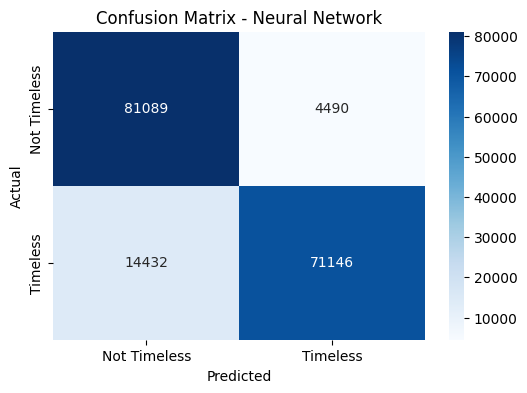

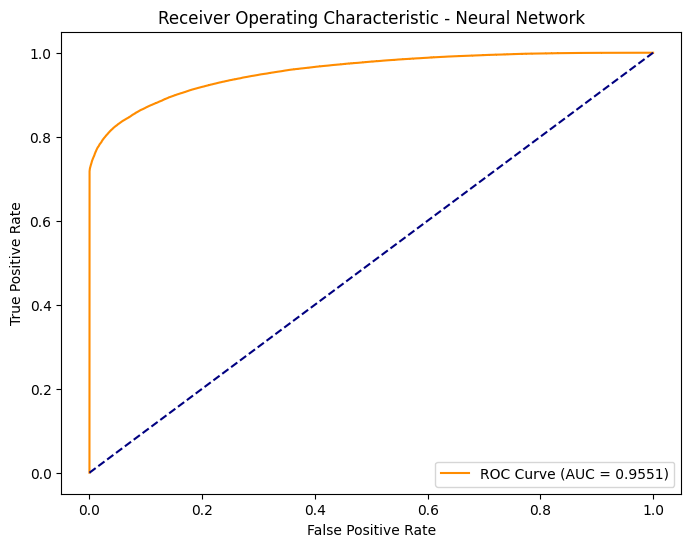

Evaluation complete!


In [14]:
# Cell 11: Evaluate Neural Network

# Predict probabilities and classes on the test set
y_proba_nn = nn_model.predict(X_test).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

# Calculate ROC AUC Score
roc_auc_nn = roc_auc_score(y_test, y_proba_nn)

print("\n--- Improved Neural Network ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_nn))
print(f"ROC AUC Score: {roc_auc_nn:.4f}")

# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Timeless', 'Timeless'],
            yticklabels=['Not Timeless', 'Timeless'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Neural Network')
plt.show()

# ROC Curve
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_proba_nn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f'ROC Curve (AUC = {roc_auc_nn:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic - Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

print("Evaluation complete!")


### Neural Network Analysis and Interpretation

- **Accuracy**: **89%**, strong overall performance.
- **Precision**: Timeless (1): **94%**, Not Timeless (0): **85%**.
- **Recall**: Timeless (1): **83%** (misses some timeless tracks), Not Timeless (0): **95%**.
- **AUC**: **0.9551 (95.51%)**, excellent class separation.
- **Confusion Matrix**:  
  - **False Negatives (Timeless)**: **14,432** (reduce recall).  
  - **False Positives (Not Timeless)**: **4,490**.

#### Key Observations
- **Strength**: High precision and AUC show strong performance.  
- **Weakness**: Recall for "Timeless" is limited by false negatives.  
- **Recommendation**: Adjust threshold to improve recall for timeless tracks.
---

# **Conclusion**

1. **Data Exploration and Preprocessing**:  
   - We explored and cleaned a Spotify dataset, engineered meaningful features, and addressed class imbalance using SMOTE.  
   - The data preprocessing steps ensured high-quality inputs for training robust models.

2. **Model Development and Evaluation**:  
   - We built and evaluated three models:  
     - **Logistic Regression**: Strong baseline with **88% accuracy** and **AUC of 94.54%**, excelling in recall for the "Not Timeless" class but missing some "Timeless" tracks.  
     - **Support Vector Machine (SVM)**: Trained on a subset of 50,000 samples due to computational constraints, achieving **83% accuracy** and **AUC of 91.48%**. Performance was balanced but slightly lower than Logistic Regression and the Neural Network.  
     - **Feedforward Neural Network**: Achieved the best overall performance with **89% accuracy**, **AUC of 95.51%**, and strong precision for the "Timeless" class (**94%**). However, false negatives for the "Timeless" class remain a challenge, reducing recall (**83%**).  

3. **Performance Comparison**:  
   - The **Neural Network** excelled in capturing complex relationships with the highest precision, recall, and AUC, making it the best-performing model.  
   - **Logistic Regression** offered a reliable baseline, outperforming SVM in most metrics.  
   - **SVM**, while computationally expensive, provided balanced results but underperformed compared to the other two models due to limited training data.

4. **Next Steps**:  
   - **Threshold Tuning**: Adjust decision thresholds in the Neural Network to improve recall for the "Timeless" class while maintaining high precision.  
   - **Advanced Architectures**: Explore deeper architectures (e.g., CNNs, RNNs) or ensemble methods to capture more nuanced patterns.  
   - **Efficiency Improvements**: Investigate dimensionality reduction techniques (e.g., PCA) for models like SVM to handle larger datasets.  
   - **Deployment**: Deploy the Neural Network as the primary model in a production environment to predict track timelessness and gather real-world feedback for further optimization.


In [ ]:
# nn_model.save("timeless_tracks_model.h5")
